In [42]:
import os
from PIL import Image, ImageFile
from torchvision import datasets, transforms, models
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [43]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\USER\.cache\kagglehub\datasets\misrakahmed\vegetable-image-dataset\versions\1


In [44]:
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Betöltés ImageFolder segítségével
train_dataset = datasets.ImageFolder(
    root="C:\\Users\\USER\\.cache\\kagglehub\\datasets\\misrakahmed\\vegetable-image-dataset\\versions\\1\\Vegetable Images\\train",
    transform=transform
)

val_dataset = datasets.ImageFolder(
    root="C:\\Users\\USER\\.cache\\kagglehub\\datasets\\misrakahmed\\vegetable-image-dataset\\versions\\1\\Vegetable Images\\validation",
    transform=transform
)


# DataLoader a batch-ek kezelésére
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)

In [45]:
print(train_dataset.classes) 

print(train_dataset.class_to_idx)  

print(len(val_loader))  

['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
{'Bean': 0, 'Bitter_Gourd': 1, 'Bottle_Gourd': 2, 'Brinjal': 3, 'Broccoli': 4, 'Cabbage': 5, 'Capsicum': 6, 'Carrot': 7, 'Cauliflower': 8, 'Cucumber': 9, 'Papaya': 10, 'Potato': 11, 'Pumpkin': 12, 'Radish': 13, 'Tomato': 14}
12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7808123].


Label: 0 - Class: Bean


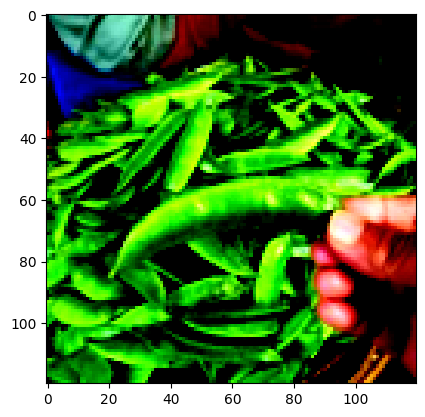

In [46]:
image, label = train_dataset[5]

print(f"Label: {label} - Class: {train_dataset.classes[label]}")

plt.imshow(image.permute(1, 2, 0))
plt.show()

In [ ]:
train_losses, train_accuracies = [], []
patience = 2
best_val_loss = float('inf') 
epochs_no_improve = 0
epoch = 0 
early_stopping = True 

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 15) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5): 
    model.train()
    running_loss = 0.0  # To accumulate loss over the epoch
    running_correct = 0  # To count correct predictions
    total = 0  # Total number of samples processed
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()  # Accumulate the loss
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class (index of max value)
        total += labels.size(0)  # Keep track of total samples
        running_correct += (predicted == labels).sum().item()  # Count correct predictions
        # Calculate loss and accuracy for this batch
        batch_loss = loss.item()
        batch_accuracy = 100 * (predicted == labels).sum().item() / labels.size(0)

        # Calculate running average loss and accuracy over all batches so far
        running_loss_avg = running_loss / (batch_idx + 1)
        running_accuracy_avg = 100 * running_correct / total

        train_losses.append(running_loss_avg)  # Save running average loss
        train_accuracies.append(running_accuracy_avg)  # Save running average accuracy

        print(f"Batch {batch_idx+1}/{len(train_loader)}, "
              f"Batch Loss: {batch_loss:.4f}, Batch Accuracy: {batch_accuracy:.2f}%, "
              f"Running Avg Loss: {running_loss_avg:.4f}, Running Avg Accuracy: {running_accuracy_avg:.2f}%")
        
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss = val_loss / len(val_loader)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0  
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break
    

model.eval() 
val_loss = 0.0
val_correct = 0 
val_total = 0 
val_preds, val_labels = [], []  

    # Turn off gradient calculation for validation (improves speed and memory)
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

            # Get model predictions
        outputs = model(images)
        loss = criterion(outputs, labels)  # Calculate validation loss
        val_loss += loss.item()  # Accumulate validation loss

            # Get the predicted class
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)  # Keep track of total validation samples
        val_correct += (predicted == labels).sum().item()  # Count correct predictions

        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

    # Calculate average validation loss and accuracy
val_loss_avg = val_loss / len(val_loader)
val_accuracy_avg = 100 * val_correct / val_total

print(f"Validation Loss: {val_loss_avg:.4f}, Validation Accuracy: {val_accuracy_avg:.2f}%\n")

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Batch 1/59, Batch Loss: 2.9110, Batch Accuracy: 8.59%, Running Avg Loss: 2.9110, Running Avg Accuracy: 8.59%
Batch 2/59, Batch Loss: 1.1238, Batch Accuracy: 74.61%, Running Avg Loss: 2.0174, Running Avg Accuracy: 41.60%
Batch 3/59, Batch Loss: 0.5150, Batch Accuracy: 85.94%, Running Avg Loss: 1.5166, Running Avg Accuracy: 56.38%
Batch 4/59, Batch Loss: 0.3210, Batch Accuracy: 92.58%, Running Avg Loss: 1.2177, Running Avg Accuracy: 65.43%
Batch 5/59, Batch Loss: 0.1965, Batch Accuracy: 95.31%, Running Avg Loss: 1.0135, Running Avg Accuracy: 71.41%
Batch 6/59, Batch Loss: 0.1320, Batch Accuracy: 97.66%, Running Avg Loss: 0.8665, Running Avg Accuracy: 75.78%
Batch 7/59, Batch Loss: 0.1292, Batch Accuracy: 96.48%, Running Avg Loss: 0.7612, Running Avg Accuracy: 78.74%
Batch 8/59, Batch Loss: 0.2033, Batch Accuracy: 92.97%, Running Avg Loss: 0.6915, Running Avg Accuracy: 80.52%
Batch 9/59, Batch Loss: 0.1112, Batch Accuracy: 96.88%, Running Avg Loss: 0.6270, Running Avg Accuracy: 82.34%
Bat

In [48]:
precision = precision_score(val_labels, val_preds, average="weighted")
recall = recall_score(val_labels, val_preds, average="weighted")
f1 = f1_score(val_labels, val_preds, average="weighted")

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Precision: 0.9772, Recall: 0.9737, F1 Score: 0.9738


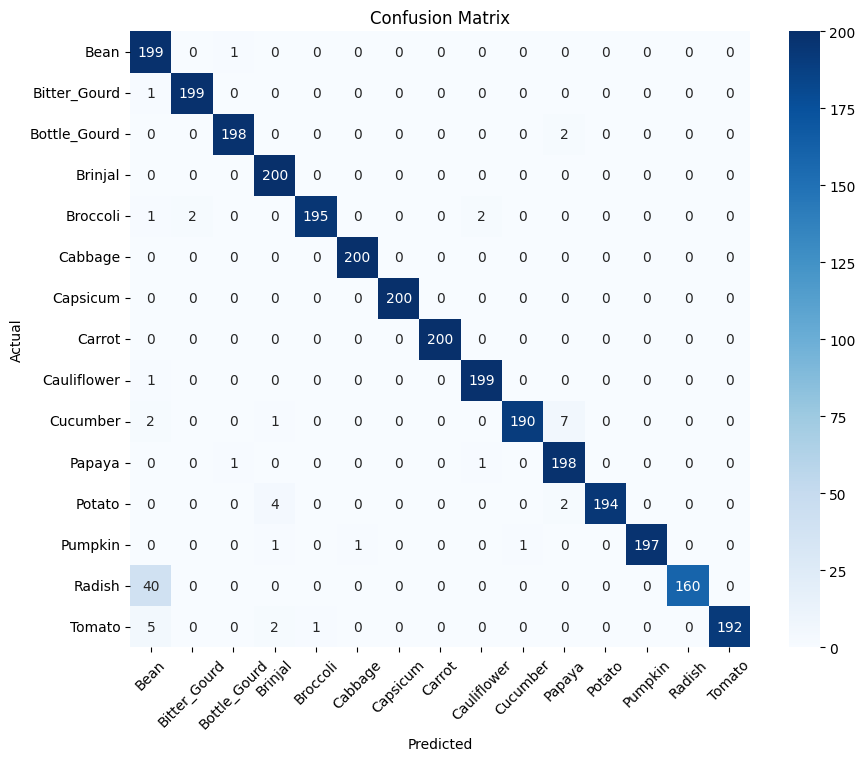

In [ ]:
# Assuming val_labels and val_preds are already defined
conf_matrix = confusion_matrix(val_labels, val_preds)

class_labels = train_dataset.classes

plt.figure(figsize=(10,8))  # Adjust plot size to accommodate 15 classes
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)  # Display matrix with 15 class labels
plt.title("Confusion Matrix")  # Add title
plt.ylabel('Actual')  # Label for y-axis
plt.xlabel('Predicted')  # Label for x-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.show()  # Show the plot


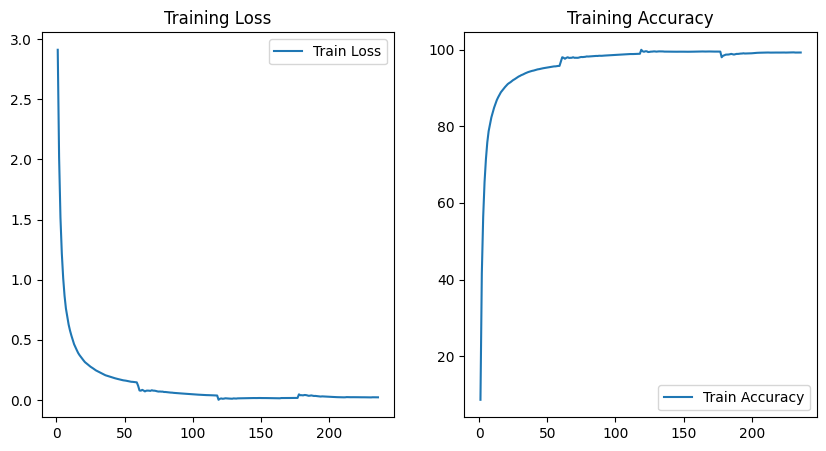

In [ ]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # Subplot for training loss
plt.plot(epochs_range, train_losses, label='Train Loss')  # Plot train loss
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.subplot(1, 2, 2)  # Subplot for training accuracy
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')  # Plot train accuracy
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.show()  # Show the plots

# QAT Extra feladat megoldása

In [ ]:
train_losses, train_accuracies = [], []

model_qat = models.resnet18(pretrained=True)
model_qat.fc = nn.Linear(512, 15) 


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_qat.parameters(), lr=0.001)

model_qat.train()
model_qat.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')  # Set quantization configuration
torch.quantization.prepare_qat(model_qat, inplace=True)

for epoch in range(2): 
    
    running_loss = 0.0  # To accumulate loss over the epoch
    running_correct = 0  # To count correct predictions
    total = 0  # Total number of samples processed
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        model_qat.train()
        
        optimizer.zero_grad()
        outputs = model_qat(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()  # Accumulate the loss
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class (index of max value)
        total += labels.size(0)  # Keep track of total samples
        running_correct += (predicted == labels).sum().item()  # Count correct predictions
        # Calculate loss and accuracy for this batch
        batch_loss = loss.item()
        batch_accuracy = 100 * (predicted == labels).sum().item() / labels.size(0)

        # Calculate running average loss and accuracy over all batches so far
        running_loss_avg = running_loss / (batch_idx + 1)
        running_accuracy_avg = 100 * running_correct / total

        train_losses.append(running_loss_avg)  # Save running average loss
        train_accuracies.append(running_accuracy_avg)  # Save running average accuracy

        print(f"Batch {batch_idx+1}/{len(train_loader)}, "
              f"Batch Loss: {batch_loss:.4f}, Batch Accuracy: {batch_accuracy:.2f}%, "
              f"Running Avg Loss: {running_loss_avg:.4f}, Running Avg Accuracy: {running_accuracy_avg:.2f}%")
    

model_qat.eval() 
torch.quantization.convert(model, inplace=True)
val_loss = 0.0
val_correct = 0 
val_total = 0 
val_preds, val_labels = [], []  

    # Turn off gradient calculation for validation (improves speed and memory)
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

            # Get model predictions
        outputs = model_qat(images)
        loss = criterion(outputs, labels)  # Calculate validation loss
        val_loss += loss.item()  # Accumulate validation loss

            # Get the predicted class
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)  # Keep track of total validation samples
        val_correct += (predicted == labels).sum().item()  # Count correct predictions

        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

    # Calculate average validation loss and accuracy
val_loss_avg = val_loss / len(val_loader)
val_accuracy_avg = 100 * val_correct / val_total

print(f"Validation Loss: {val_loss_avg:.4f}, Validation Accuracy: {val_accuracy_avg:.2f}%\n")

Batch 1/59, Batch Loss: 3.0113, Batch Accuracy: 11.33%, Running Avg Loss: 3.0113, Running Avg Accuracy: 11.33%
Batch 2/59, Batch Loss: 1.3231, Batch Accuracy: 66.80%, Running Avg Loss: 2.1672, Running Avg Accuracy: 39.06%
Batch 3/59, Batch Loss: 0.8470, Batch Accuracy: 84.77%, Running Avg Loss: 1.7271, Running Avg Accuracy: 54.30%
Batch 4/59, Batch Loss: 0.6169, Batch Accuracy: 89.84%, Running Avg Loss: 1.4496, Running Avg Accuracy: 63.18%
Batch 5/59, Batch Loss: 0.4611, Batch Accuracy: 92.19%, Running Avg Loss: 1.2519, Running Avg Accuracy: 68.98%
Batch 6/59, Batch Loss: 0.3782, Batch Accuracy: 93.36%, Running Avg Loss: 1.1063, Running Avg Accuracy: 73.05%
Batch 7/59, Batch Loss: 0.2542, Batch Accuracy: 96.88%, Running Avg Loss: 0.9845, Running Avg Accuracy: 76.45%
Batch 8/59, Batch Loss: 0.1953, Batch Accuracy: 96.88%, Running Avg Loss: 0.8859, Running Avg Accuracy: 79.00%
Batch 9/59, Batch Loss: 0.1424, Batch Accuracy: 98.83%, Running Avg Loss: 0.8033, Running Avg Accuracy: 81.21%
B

In [53]:
precision = precision_score(val_labels, val_preds, average="weighted")
recall = recall_score(val_labels, val_preds, average="weighted")
f1 = f1_score(val_labels, val_preds, average="weighted")

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Precision: 0.9693, Recall: 0.9627, F1 Score: 0.9634


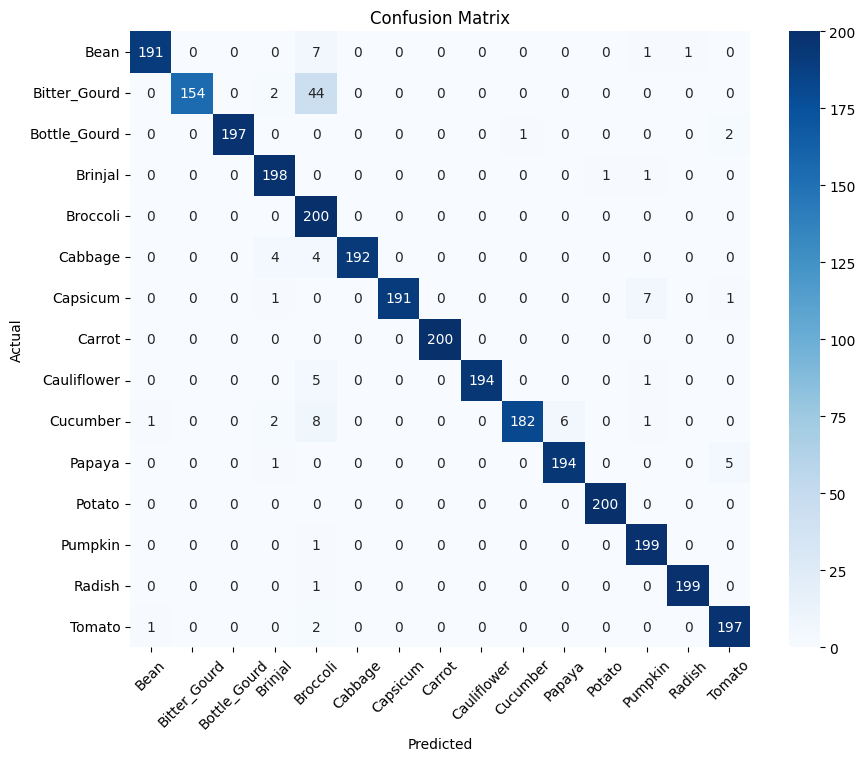

In [54]:
# Assuming val_labels and val_preds are already defined
conf_matrix = confusion_matrix(val_labels, val_preds)

class_labels = train_dataset.classes

plt.figure(figsize=(10,8))  # Adjust plot size to accommodate 15 classes
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)  # Display matrix with 15 class labels
plt.title("Confusion Matrix")  # Add title
plt.ylabel('Actual')  # Label for y-axis
plt.xlabel('Predicted')  # Label for x-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.show()  # Show the plot
